<table>
 <tr align=left><td><img align=left src="./images/CC-BY.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>

Note:  The presentation below largely follows part II in "Finite Difference Methods for Ordinary and Partial Differential Equations" by LeVeque (SIAM, 2007).

In [10]:
from __future__ import print_function

%matplotlib inline
import numpy
import matplotlib.pyplot as plt

# Numerical Solution to ODE Initial Value Problems - Part 2

# Overview -- so far

So far we have discussed 3 basic techniques for integration of ODE IVP's

* **Single-Step Multi-Stage** schemes (explicit and implicit)
* **Taylor's Series** Methods
* **Linear Multi-Step** Schemes (explicit and implicit)

as well as 
* **truncation error** of each method (and it's relation to step-error)
* **adaptive stepping** 

# Overview -- to do

This notebook will take the analysis of these methods to discuss the other important issues of
* **Convergence** (Global Error) -- does the discrete solution converge to the continuous analytic solution?
* **Stability** -- Are there limits to how large a time-step we can take?
* **Stiff Equations**:  consequences of stability

# Convergence

We can think of an ODE method as providing a sequence of approximations $U_N$ where here $N$ is the number of time steps needed to reach the final time of interest $t_f$, in effect we are increasing the resolution of the method.  We then say that a method is convergent if this sequence converges to the true solution at the same time
$$
    \lim_{N\rightarrow \infty} U_N = u(t_f).
$$

We can also define this in a more familiar way in terms of $\Delta t$ such that
$$
    N \Delta t = t_f ~~~~ \Rightarrow ~~~~ N = \frac{t_f}{\Delta t}
$$
so that our definition of convergence becomes
$$
    \lim_{\Delta t \rightarrow 0} U_{\Delta t} = u(t_f).
$$

In general for a method to be convergent it must be
 - **consistent** which as before meant that the local truncation error $T = \mathcal{O}(\Delta t^p)$ where $p > 0$,
 - **zero-stable** which implies that the sum total of the errors as $\Delta t \rightarrow 0$ is bounded and has the same order as $T$ (the truncation error) which we know goes to zero as $\Delta t \rightarrow 0$.
 
 
put another way,  a method is convergent if the **global error**

$$
    E = | U_N(t_f) - u(t_f)| \rightarrow 0\quad\mathrm{as}\quad N\rightarrow\infty
$$

### Example:  Forward Euler on a Linear Problem

Consider the simple linear problem
$$
    \frac{\text{d}u}{\text{d}t} = \lambda u \quad \text{with} \quad u(0) = u_0
$$
which we know has the solution $u(t) = u_0 e^{\lambda t}$.  Applying Euler's method to this problem leads to 
$$\begin{aligned}
    U_{n+1} &= U_n + \Delta t\lambda U_n \\
            &= (1 + \Delta t \lambda) U_n
\end{aligned}$$

We also know the local truncation error is defined by
$$\begin{aligned}
    T_n &= \frac{1}{\Delta t} \left[ U_{n+1} - u_{n+1} \right ] \\
        &= \frac{1}{\Delta t} \left[ (1 + \lambda \Delta t) u_n - u_{n+1} \right ]
\end{aligned}$$
which can be rearranged to find

$$
    u_{n+1} = (1 + \Delta t \lambda) u_n - \Delta t T_n.
$$

Note that all values here are in terms of the exact solution where as the application of Euler's method is in terms of the approximate solution.

Defining the global error as
$$
    E_{n} = u_n - U_n
$$

we can subtract the last two expressions to find

$$\begin{aligned}
    u_{n+1} - U_{n+1} &= \underbrace{(1 + \Delta t \lambda) u_n - \Delta t T_n}_{u_{n+1}} - \underbrace{(1 + \Delta t \lambda) U_n}_{U_{n+1}} \\
    E_{n+1} &= (1 + \Delta t \lambda) (u_n - U_n) - \Delta t T_n \\
            &= (1 + \Delta t \lambda) E_n - \Delta t T_n,
\end{aligned}$$

a recursive definition for the global error that connects it to the local truncation error.

Working backwards from the global error $E_n$ at maximum time step $n = t_f/\Delta t$,  the first few iterates of this look like

$$\begin{align}
    E_n &= (1 + \lambda \Delta t) E_{n - 1} - \Delta t T_{n-1} \\
    &= (1 + \lambda \Delta t) \left [(1 + \lambda \Delta t) E_{n - 2} - \Delta t T_{n-2} \right ] - \Delta t T_{n-1} \\
    &= (1 + \lambda \Delta t) \left [(1 + \lambda \Delta t) \left \{(1 + \lambda \Delta t) E_{n - 3} - \Delta t T_{n-3} \right \} - \Delta t T_{n-2} \right ] - \Delta t T_{n-1}
\end{align}$$

Which at this point looks like
$$
    E_n = (1 + \lambda \Delta t)^3E_{n-3} - \Delta t\sum_{i=1}^3 (1+\Delta t\lambda)^{i-1}T_{n-i}
$$

So taking it back $n$ steps ($3\rightarrow n$) gives
Which at this point looks like
$$
    E_n = (1 + \lambda \Delta t)^nE_0 - \Delta t\sum_{i=1}^n (1+\Delta t\lambda)^{i-1}T_{n-i}
$$

Expanding this expression out backwards in time to $n=0$ leads to 
$$
    E_n = (1 + \Delta t \lambda)^n E_0 - \Delta t \sum^n_{i=1} (1 + \Delta t \lambda)^{i-1} T_{n - i}.
$$

Noting that $(1 + \Delta t \lambda)$ are the first two terms in the Taylor series for $e^{\lambda\Delta t}$ we will bound this term by

$$
    e^{\Delta t \lambda} \geq |1 + \Delta t \lambda|
$$

which then implies the term in the summation can be bounded by

$$
    |1 + \Delta t \lambda|^{i - 1} \leq e^{(n-1) \Delta t |\lambda|} \leq e^{n \Delta t |\lambda||} \leq e^{|\lambda| t_f}
$$

Using this expression in the expression for the global error we find
$$\begin{aligned}
    E_n &= (1 + \Delta t \lambda)^n E_0 - \Delta t \sum^n_{i=1} (1 + \Delta t \lambda)^{i-1} T_{n-i} \\
    |E_n| &\leq e^{|\lambda| \Delta t n} |E_0| + \Delta t \sum^n_{i=1} e^{|\lambda| t_f} |T_{n-i}| \\
          &\leq e^{|\lambda| t_f} \left(|E_0| + \Delta t \sum^n_{i=1} |T_{n - i}|\right) \\
          &\leq e^{|\lambda| t_f} \left(|E_0| + n \Delta t \max_{1 \leq i \leq n} |T_{n - i}|\right)
\end{aligned}$$

In other words the global error is bounded by the original global error and the maximum one-step error made multiplied by the number of time steps taken.  If $N = \frac{t_f}{\Delta t}$ as before and taking into account the local truncation error we can simplify this expression further to

$$
    |E_n| \leq e^{|\lambda| t_f} \left[|E_0| + t_f \left(\frac{1}{2} \Delta t |u''| + \mathcal{O}(\Delta t^2)\right ) \right]
$$

If we assume that we have used the correct initial condition $u_0$ then $E_0 \rightarrow 0$ as $\Delta t \rightarrow 0$ and we see that the global error $E_n$ is bounded by $\mathcal{O}(\Delta t)$, the same as the local truncation error:
$$
    |E_n| \leq e^{|\lambda| t_f} t_f \left(\frac{1}{2} \Delta t |u''| + \mathcal{O}(\Delta t^2)\right ) = \mathcal{O}(\Delta t).
$$

More generally,  it can be shown that for all single-step multi-stage schemes (of which Euler is the simplest), the Global error has the same order as the Truncation error, and therefore all of these schemes converge.

## Absolute Stability
Although zero-stability guarantees stability it is much more difficult to work with in general as the limit $\Delta t \rightarrow 0$ can be difficult to compute (and in general isn't ideal as it requires an infinite amount of computation).  Instead we often consider a finite $\Delta t$ and examine if the method is stable for this particular choice of $\Delta t$.  This has the practical upside that it will also tell us what particular $\Delta t$ will ensure that our method is indeed stable.

### Example
Consider the problem
$$
    u'(t) = \lambda (u - \cos t) - \sin t ~~~~ \text{with} ~~~~ u(0) = 1
$$

whose exact solution is 
$$
    u(t) = \cos t.
$$

We can compute an estimate for what $\Delta t$ we need to use by examining the truncation error for Euler's method

$$\begin{aligned}
    T &= \frac{1}{2} \Delta t u''(t) + \mathcal{O}(\Delta t^2) \\
      &= -\frac{1}{2} \Delta t \cos t + \mathcal{O}(\Delta t^2)
\end{aligned}$$

and therefore
$$
    |E_n| \leq \Delta t \max_{0 \leq t \leq t_f} |\cos t| = \Delta t.
$$

If we want a solution where $|E_n| < 10^{-3}$ then $\Delta t \approx 10^{-3}$.  Turning to the application of Euler's method lets apply this to the case where $\lambda = -10$ and $\lambda = -2100$.

In [11]:
# Implement Forward Euler
def euler(f, t_span, u0, N):
    """ simple implementation of constant step-size forward euler method
        This doc string should have so much more in it
    """
    t = numpy.linspace(t_span[0], t_span[1],N)
    u = numpy.empty(t.shape)
    u[0] = u0
    delta_t = t[1] - t[0]
    for (n, t_n) in enumerate(t[:-1]):
        K1 = delta_t * f(t_n, u[n])
        u[n + 1] = u[n] + K1        
    return t, u

In [12]:
# Compare accuracy between Euler for different values of lambda
f = lambda t, u, lam: lam * (u - numpy.cos(t)) - numpy.sin(t)
u_exact = lambda t: numpy.cos(t)
u_0 = u_exact(0.)

t_span = [0., 2.]
num_steps = [2**n for n in range(4, 9)]

Error: lambda =   10: [0.00585379 0.00265873 0.00126757 0.00061895 0.00030584]
Error: lambda = 2100: [3.68031712e+032 3.59591175e+061 5.64801260e+109 1.70130252e+186
 9.46746847e+297]


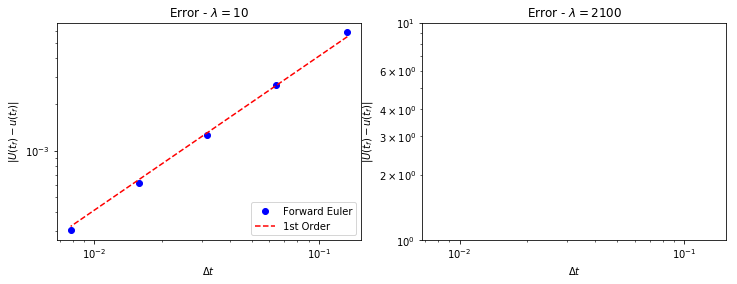

In [13]:
#num_steps = [2**n for n in range(15,20)]
delta_t = numpy.empty(len(num_steps))
error_10 = numpy.empty(len(num_steps))
error_2100 = numpy.empty(len(num_steps))

t_f = t_span[1]
u_f = u_exact(t_f)

for (i, N) in enumerate(num_steps):
    # Compute Euler solution
    ff = lambda t, u: f(t, u, -10.)
    t, U_10 = euler(ff, t_span, u_0, N) 
    delta_t[i] = t[1] - t[0]
    error_10[i] = numpy.abs(U_10[-1] - u_f) / numpy.abs(u_f)
    ff = lambda t, u: f(t, u, -2100.)    
    t, U_2100 = euler(ff, t_span, u_0, N) 
    error_2100[i] = numpy.abs(U_2100[-1] - u_f) / numpy.abs(u_f)

print('Error: lambda =   10: {}'.format(error_10))
print('Error: lambda = 2100: {}'.format(error_2100))    

# Plot error vs. delta_t
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
axes = fig.add_subplot(1, 2, 1)

axes.loglog(delta_t, error_10, 'bo', label='Forward Euler')

order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
axes.loglog(delta_t, order_C(delta_t[1], error_10[1], 1.0) * delta_t**1.0, 'r--', label="1st Order")

axes.legend(loc=4)
axes.set_title("Error - $\lambda = 10$")
axes.set_xlabel("$\Delta t$")
axes.set_ylabel("$|U(t_f) - u(t_f)|$")

axes = fig.add_subplot(1, 2, 2)

axes.loglog(delta_t, error_2100, 'bo', label='Forward Euler')
axes.loglog(delta_t, order_C(delta_t[1], error_2100[1], 1.0) * delta_t**1.0, 'r--', label="1st Order")

axes.set_title("Error - $\lambda = 2100$")
axes.set_xlabel("$\Delta t$")
axes.set_ylabel("$|U(t_f) - u(t_f)|$")

plt.show()

So what went wrong with $\lambda = -2100$, the global error should go as

$$
    E_n = \mathcal{O}(\Delta t)?
$$

If $\Delta t \approx 10^{-3}$ then for the case $\lambda = -10$ the previous **global error** is multiplied by $1+\lambda\Delta t$

$$1 + 10^{-3} \cdot -10 = 0.99$$

which means the contribution from $E^n$ will slowly decrease as we take more time steps.  For the other case we have

$$1 + 10^{-3} \cdot -2100 = -1.1$$

which means that for this $\Delta t$ the error made in previous time steps will grow!  For this not to happen we would have to have $\Delta t < 1 / 2100$ which would lead to convergence again.

### A simpler example
Consider our simplest test problem
$$
    u'(t) = \lambda u, \quad u(0) = u_0
$$

whose exact solution is 
$$
    u(t) = u_0 e^{\lambda t}.
$$
which for real $\lambda < 0$ should decay to zero as $t\rightarrow\infty$ 

### Question?

What is the **largest** step-size $\Delta t$ for an Euler method, such that the discrete solution $U_N\rightarrow 0$ as $N\rightarrow\infty$?

Euler's method on this simplest problem can be written

$$
\begin{align}
    U_{n+1} &= U_n + \Delta t f(U_n) = U_n + \Delta t \lambda U_n\\
            &= (1 + \lambda\Delta t)U_n\\
\end{align}
$$            

i.e. at each step the last solution is multiplied by the factor $(1 + \lambda\Delta t)$

After $N$ steps

$$
    U_N = (1 + \lambda\Delta t)^N U_0
$$ 

Assuming $\lambda < 1$ what is the largest step size $\Delta t$ such that $U_N\rightarrow 0$ as $N\rightarrow\infty$?


Hopefully it's clear that for this scheme to be stable requires

$$
    |1 + \lambda\Delta t| < 0
$$

The key parameter is actually the combination of $\lambda$ and the time stepm $z=\lambda\Delta t$, so stability requires that

$$
    | 1 + z | < 0
$$
or  𝑧∈[?,?]

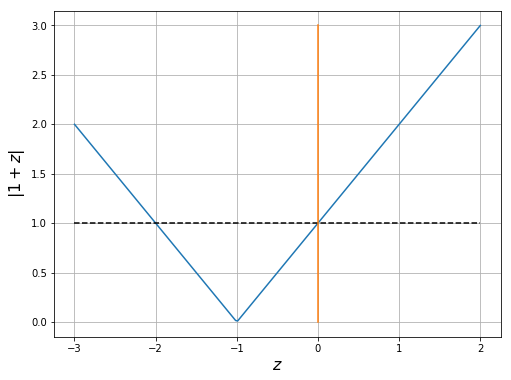

In [31]:
plt.figure(figsize=(8,6))
z = numpy.linspace(-3,2,200)
plt.plot(z,numpy.abs(1 + z))
plt.plot(z,numpy.ones(z.shape),'k--')
plt.plot([0.,0],[0.,3.])
plt.xlabel('$z$',fontsize=16)
plt.ylabel('$|1 + z|$',fontsize=16)
plt.grid()
plt.show()


Given $z\in[-2,0]$,  the  time step is simply

$$
    \Delta t = \frac{z}{\lambda}
$$
so the maximum time step we can take for $\lambda<0$ is

$$
    \Delta t = -\frac{2}{\lambda} > 0
$$


In [80]:
# Compare accuracy between Euler for different values of time steps and $\lambda = -1$
lam = -1.
f = lambda t, u :  lam * u
u_exact = lambda t: numpy.exp(lam * t)
u_0 = u_exact(0.)

t_span = [0., 10.]

N = 21
#N = 11
#N = 6
#N = 5
t, u = euler(f, t_span, u_0, N)


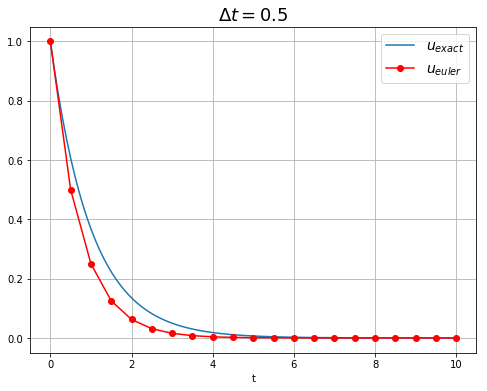

In [81]:
tt = numpy.linspace(0.,t_span[1],100)
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1,1,1)
axes.plot(tt, u_exact(tt),label='$u_{{exact}}$')
axes.plot(t, u, 'ro-', label='$u_{{euler}}$')
axes.set_xlabel('t')
axes.set_title('$\Delta t = {}$'.format(t[1]-t[0]), fontsize=18)
axes.grid()
axes.legend(loc='best',fontsize=14)
plt.show()


### Absolute Stability of the Forward Euler Method for complex $z$

The region $|1 + z| < 1$  is the **region of absolute stability**.  For more general problems $\lambda$ may be complex (stemming from eigenvalues of real problems),  so we generally consider the region of stability on the complex plane.

$$
    | 1 + z | < 1
$$
for $z\in\mathbb{C}$

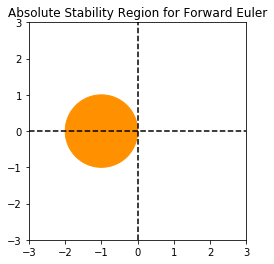

In [14]:
# Plot the region of absolute stability for Forward Euler
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

t = numpy.linspace(0.0, 2.0 * numpy.pi, 100)

axes.fill(numpy.cos(t) - 1.0, numpy.sin(t), color=(255.0/255.0,145.0/255.0,0/255.0,1.0))
axes.plot([-3, 3],[0.0, 0.0],'k--')
axes.plot([0.0, 0.0],[-3, 3],'k--')
axes.set_xlim((-3, 3.0))
axes.set_ylim((-3,3))
axes.set_aspect('equal')

axes.set_title("Absolute Stability Region for Forward Euler")
plt.show()

### Absolute Stability of Single-Step Multi-Stage schemes -- The R method

This approach can be applied to all Single-Step Multi-Stage schemes including all the Runge-Kutta and Taylor Series methods.  The recipe is straightforward

*  Apply the stepping scheme for one step of the test problem $u' = \lambda u$, $u(0)=u_0$ assuming complex $\lambda$
*  This will result in a discrete approximation

$$
    U(\Delta t) = R(z) U_0
$$
where $z=\lambda\Delta t\in\mathbb{C}$, which will be a discrete approximation to the true solution
$$
    U(\Delta t) = e^{z} U_0
$$
* Absolute stability will require that $|R(z)| < 1$

### Absolute Stability of the backward Euler Method

Now try this on backward Euler.

$$
    U_{n+1} = U_n + \Delta t f(t_{n+1}, U_{n+1}).
$$

The backward version of Euler's method is defined as

$$
    U_{n+1} = U_n + \Delta t f(t_{n+1}, U_{n+1}).
$$

If we again consider the test problem from before we find that

$$\begin{aligned}
    0 &= U_{n+1} (1 - \Delta t \lambda) - U_n \\
    &= \xi (1 - z) - 1
\end{aligned}$$

which has the root $\xi = \frac{1}{1 - z}$.  We then have

$$\left|\frac{1}{1-z}\right| \leq 1 \leftrightarrow |1 - z| \geq 1$$

so in fact the stability region encompasses the entire complex plane except for a circle centered at $(1, 0)$ of radius 1 implying that the backward Euler method is in fact stable for any choice of $\Delta t$.

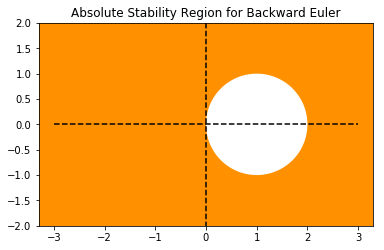

In [16]:
# Plot the region of absolute stability for Backward Euler
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

t = numpy.linspace(0.0, 2.0 * numpy.pi, 100)

axes.set_facecolor((255.0/255.0,145.0/255.0,0/255.0,1.0))
axes.fill(numpy.cos(t) + 1.0, numpy.sin(t), 'w')
axes.plot([-3, 3],[0.0, 0.0],'k--')
axes.plot([0.0, 0.0],[-3, 3],'k--')
# axes.set_xlim((-3, 1))
axes.set_ylim((-2,2))
axes.set_aspect('equal')

axes.set_title("Absolute Stability Region for Backward Euler")
plt.show()

### Characteristic Polynomials and Linear Difference Equations

To help us analyze stability regions we will take a small aside and consider linear difference equations and their solutions.  Say we wanted to solve

$$\sum^r_{j=0} \alpha_j U_{n+j} = 0$$

given initial conditions $U_0, U_1, \ldots, U_{r-1}$.  This expression has a solution in the general form $U_n = \xi^n$.  

Plugging this into the equation we have

$$\sum^r_{j=0} \alpha_j \xi^{n+j} = 0$$

which simplifies to

$$\sum^r_{j=0} \alpha_j \xi^j = 0 $$

by dividing by $\xi^n$.  If $\xi$ then is a root of the polynomial

$$\rho(\xi) \equiv \sum^r_{j=0} \alpha_j \xi^j$$

then $\xi$ solves the original difference equation.

### General Stability Regions for Linear Methods

Going back to our stability region discussions we can consider any of the methods we outlined in the last lecture applied to our test problem as a general linear difference equation
$$
    \sum^r_{j=0} \alpha_j U_{n+j} = \Delta t \sum^r_{j=0} \beta_j \lambda U_{n+j}
$$
which can be written as 
$$
    \sum^r_{j=0} (\alpha_j - \beta_j \Delta t \lambda) U_{n+j} = 0
$$
or using our notation of $z = \Delta t \lambda$ we have
$$
    \sum^r_{j=0} (\alpha_j - \beta_j z) U_{n+j} = 0.
$$
This has a similar form to the linear difference equations considered above! 

Let
$$
    \rho(\xi) = \sum^r_{j=0} \alpha_j \xi^j
$$
and 
$$
    \sigma(\xi) = \sum^r_{j=0} \beta_j \xi^j
$$
we can write the expression above as
$$
    \pi(\xi, z) = \rho(\xi) - z \sigma(\xi)
$$
called the **stability polynomial** of the method.  

It turns out that if the roots $\xi_i$ of $\pi(\xi, z)$ satisfy
$$
    |\xi_i| \leq 1
$$
then the multi-step method is zero-stable.  Roughly you can think of these roots as multiplying the past truncation errors so that if they are less than or equal to 1 they do not grow in magnitude.  We then define the region of absolute stability as the values for $z$ for which this is true.  This approach can also be applied to one-step methods as a special case.

### Example:  Forward Euler's Method

Examining forward Euler's method we have

$$\begin{aligned}
    0 &= U_{n+1} - U_n - \Delta t \lambda U_n \\
    &= U_{n+1} - U_n (1 + \Delta t \lambda)\\
    &= \xi - 1 (1 + z)\\
    &=\pi(\xi, z)
\end{aligned}$$

whose root is $\xi = 1 + z$ and we have re-derived the stability region we had found before.

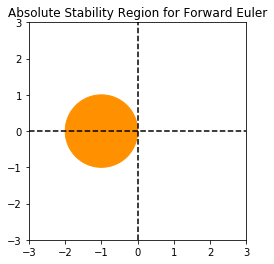

In [15]:
# Plot the region of absolute stability for Forward Euler
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

t = numpy.linspace(0.0, 2.0 * numpy.pi, 100)

axes.fill(numpy.cos(t) - 1.0, numpy.sin(t), color=(255.0/255.0,145.0/255.0,0/255.0,1.0))
axes.plot([-3, 3],[0.0, 0.0],'k--')
axes.plot([0.0, 0.0],[-3, 3],'k--')
axes.set_xlim((-3, 3.0))
axes.set_ylim((-3,3))
axes.set_aspect('equal')

axes.set_title("Absolute Stability Region for Forward Euler")
plt.show()

## Application to Stiff ODEs

Consider again the ODE we examined before

$$u'(t) = \lambda (u - \cos t) - \sin t$$

except this time with general initial condition $u(t_0) = u_0$.  What happens to solutions that are slightly different from $u_0 = 1$ or $t_0 = 0$?  The general solution of the ODE is

$$u(t) = e^{\lambda (t - t_0)} (u_0 - \cos t_0) + \cos t$$.

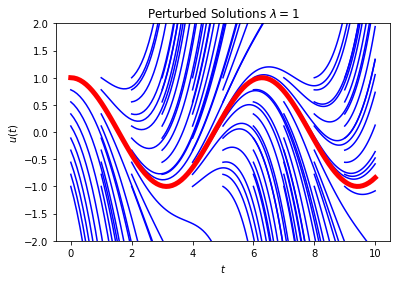

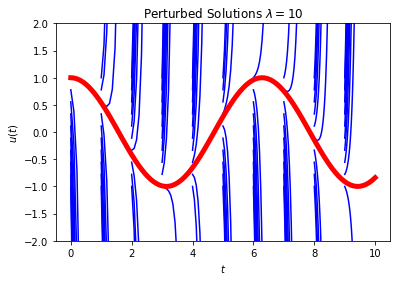

In [17]:
# Plot "hairy" solutions to the ODE
u = lambda t_0, eta, lam, t: numpy.exp(lam * (t - t_0)) * (eta - numpy.cos(t_0)) + numpy.cos(t)

for lam in [1, 10]:
    fig = plt.figure()
    axes = fig.add_subplot(1, 1, 1)
    for eta in numpy.linspace(-1, 1, 10):
        for t_0 in numpy.linspace(0.0, 9.0, 10):
            t = numpy.linspace(t_0,10.0,100)
            axes.plot(t, u(t_0, eta, lam, t),'b')
    t = numpy.linspace(0.0,10.0,100)
    axes.plot(t, numpy.cos(t), 'r', linewidth=5)
    axes.set_ylim((-2, 2))
        
    axes.set_title("Perturbed Solutions $\lambda = %s$" % lam)
    axes.set_xlabel('$t$')
    axes.set_ylabel('$u(t)$')
axes.set_ylim((-2, 2))
plt.show()
        

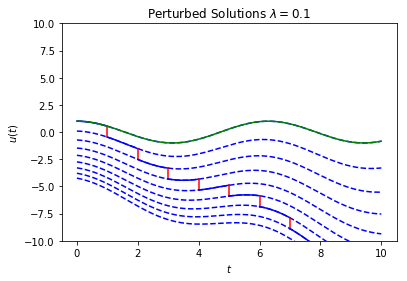

In [18]:
# Plot "inverse hairy" solutions to the ODE
u = lambda t_0, eta, lam, t: numpy.exp(lam * (t - t_0)) * (eta - numpy.cos(t_0)) + numpy.cos(t)

num_steps = 10
error = numpy.ones(num_steps) * 1.0
t_hat = numpy.linspace(0.0, 10.0, num_steps + 1)
t_whole = numpy.linspace(0.0, 10.0, 1000)

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
eta = 1.0
lam = 0.1

for n in range(1,num_steps):
    t = numpy.linspace(t_hat[n-1], t_hat[n], 100)
    U = u(t_hat[n-1], eta, lam, t)
    axes.plot(t, U, 'b')
    axes.plot(t_whole, u(t_hat[n-1], eta, lam, t_whole),'b--')
    axes.plot([t[-1], t[-1]], (U[-1], U[-1] + -1.0**n * error[n]), 'r')
    eta = U[-1] + -1.0**n * error[n]

t = numpy.linspace(0.0, 10.0, 100)
axes.plot(t, numpy.cos(t), 'g')

axes.set_title("Perturbed Solutions $\lambda = %s$" % lam)
axes.set_xlabel('$t$')
axes.set_ylabel('$u(t)$')
axes.set_ylim((-10,10))
plt.show()
        

### Example:  Chemical systems

Consider the transition of a chemical $A$ to a chemical $C$ through the process

$$A \overset{K_1}{\rightarrow} B \overset{K_2}{\rightarrow} C.$$

If we let

$$\vec{u} = \begin{bmatrix} [A] \\ [B] \\ [C] \end{bmatrix}$$

then we can model this simple chemical reaction with the system of ODEs

$$\frac{\text{d} \vec{u}}{\text{d} t} = 
\begin{bmatrix}
    -K_1 & 0 & 0 \\
    K_1 & -K_2 & 0 \\
    0 & K_2 & 0
\end{bmatrix} \vec{u}$$

The solution of this system is of the form

$$u_j(t) = c_{j1} e^{-K_1 t} + c_{j2}e^{-K_2 t} + c_{j3}$$

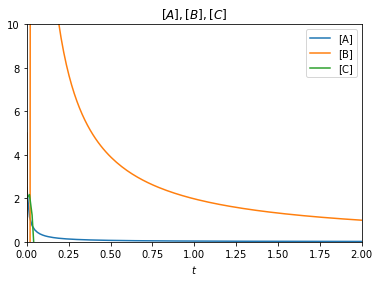

In [19]:
# Solve the chemical systems example
# Problem parameters
K_1 = 3
K_2 = 1
N = 128
K_1 = 30.0
K_2 = 1.0

A = numpy.array([[-K_1, 0, 0], [K_1, -K_2, 0], [0, K_2, 0]])
f = lambda u: numpy.dot(A, u)

t = numpy.linspace(0.0, 2.0, N)
delta_t = t[1] - t[0]

U = numpy.empty((t.shape[0], 3))
U[0, :] = [2.5, 5.0, 2.0]

for n in range(t.shape[0] - 1):
    U[n+1, :] = U[n, :] / (1.0 - delta_t * f(U[n, :]))
    
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(t, U)
axes.legend(["[A]", "[B]", "[C]"])
axes.set_title("Chemical System")
axes.set_xlabel("$t$")
axes.set_title("$[A], [B], [C]$")
axes.set_ylim((0.0, 10.))
axes.set_xlim((0.0, 2.0))

plt.show()

### What is stiffness?

In general a **stiff** ODE is one where $u'(t) \ll f'(t, u)$.  For systems of ODEs the **stiffness ratio**

$$\frac{\max_p |\lambda_p|}{\min_p |\lambda_p|}$$

can be used to characterize the stiffness of the system.  In our last example this ratio was $K_1 / K_2$ if $K_1 > K_2$.  As we increased this ratio we observed that the numerical method became unstable only a reduction in $\Delta t$ lead to stable solution again.  For explicit time step methods this is problematic as the reduction of the time step for only one of the species leads to very expensive evaluations.  For example, forward Euler has the stability criteria

$$|1 + \Delta t \lambda| < 1$$

where $\lambda$ will have to be the maximum eigenvalue of the system.  

-3.0
-1.0


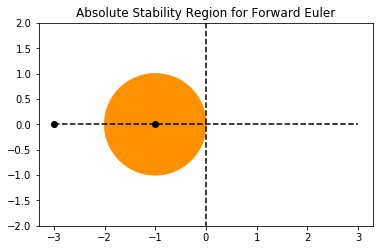

In [20]:
# Plot the region of absolute stability for Forward Euler
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

t = numpy.linspace(0.0, 2.0 * numpy.pi, 100)

# K_1 = 30.0
# K_2 = 1.0
K_1 = 3.0
K_2 = 1.0
delta_t = 1.0
eigenvalues = [-K_1, -K_2]

axes.fill(numpy.cos(t) - 1.0, numpy.sin(t), color=(255.0/255.0,145.0/255.0,0/255.0,1.0))
for lam in eigenvalues:
    print(lam * delta_t)
    axes.plot(lam * delta_t, 0.0, 'ko')
axes.plot([-3, 3],[0.0, 0.0],'k--')
axes.plot([0.0, 0.0],[-3, 3],'k--')
# axes.set_xlim((-3, 1))
axes.set_ylim((-2,2))
axes.set_aspect('equal')

axes.set_title("Absolute Stability Region for Forward Euler")
plt.show()

### A-Stability
What if we could expand the absolute stability region to encompass more of the left-half plane or even better, all of it.  A method that has this property is called **A-stable**.  We have already seen one example of this with backward Euler which as a stability region of

$$|1 - z| \geq 1$$

which covers the full left-half plane.  It turns out that for linear multi-step methods a theorem by Dahlquist proves that there are no LMMs that satisfies the A-stability criterion beyond second order (trapezoidal rule).  There are higher-order Runge-Kutta methods do however.

Perhaps this is too restrictive though.  Often large eigenvalues for systems (for instance coming from a PDE discretization for the heat equation) lie completely on the real line.  If the stability region can encompass as much of the real line as possible while leaving out the rest of the left-half plane we can possibly get a more efficient method.  There are a number of methods that can be constructed that have this property but are higher-order.

-3.0
-1.0


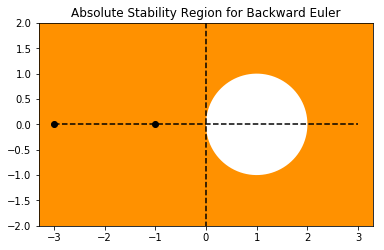

In [21]:
# Plot the region of absolute stability for Backward Euler
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

t = numpy.linspace(0.0, 2.0 * numpy.pi, 100)

K_1 = 3.0
K_2 = 1.0
delta_t = 1.0
eigenvalues = [-K_1, -K_2]

axes.set_facecolor((255.0/255.0,145.0/255.0,0/255.0,1.0))
axes.fill(numpy.cos(t) + 1.0, numpy.sin(t), 'w')
for lam in eigenvalues:
    print(lam * delta_t)
    axes.plot(lam * delta_t, 0.0, 'ko')
axes.plot([-3, 3],[0.0, 0.0],'k--')
axes.plot([0.0, 0.0],[-3, 3],'k--')
# axes.set_xlim((-3, 1))
axes.set_ylim((-2,2))
axes.set_aspect('equal')

axes.set_title("Absolute Stability Region for Backward Euler")
plt.show()

# L-Stability

It turns out not all A-stable methods are alike.  Consider the backward Euler method and the trapezoidal method defined by

$$\frac{U_{n+1} - U_n}{\Delta t} = \frac{1}{2}(f(U_n) + f(U_{n+1})$$

whose stability polynomial is

$$\begin{aligned}
    0 &= U_{n+1} - U_n - \Delta t \frac{1}{2} (\lambda U_n + \lambda U_{n+1}) \\
      &= U_{n+1}\left(1 - \frac{1}{2} \Delta t \lambda \right ) - U_n \left(1 + \frac{1}{2}\Delta t \lambda \right) \\
      &= \left(\xi - \frac{1 + \frac{1}{2}z}{1 - \frac{1}{2} z}\right) \left(1 - \frac{1}{2} z \right )\\
\end{aligned}$$
which shows that it is A-stable.  Lets apply both these methods to a problem we have seen before and see what happens.

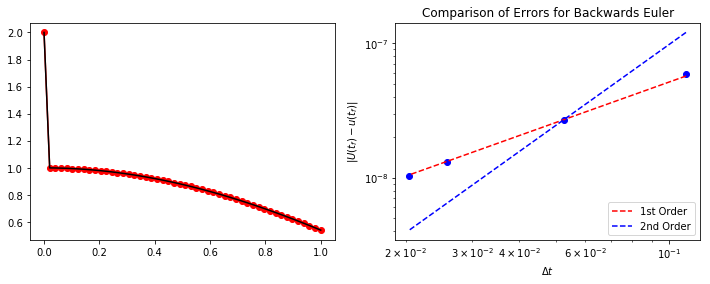

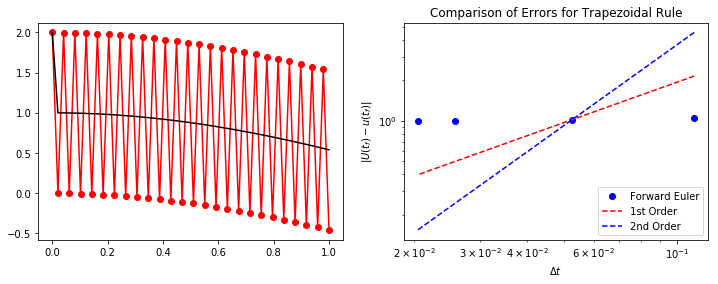

In [22]:
# Compare accuracy between Euler
f = lambda t, lam, u: lam * (u - numpy.cos(t)) - numpy.sin(t)
u_exact = lambda t_0, eta, lam, t: numpy.exp(lam * (t - t_0)) * (eta - numpy.cos(t_0)) + numpy.cos(t)

t_0 = 0.0
t_f = 1.0
eta = 2.0
lam = -1e6

num_steps = [10, 20, 40, 50]
# num_steps = numpy.arange(100, 1000, 100)

delta_t = numpy.empty(len(num_steps))
error_euler = numpy.empty(len(num_steps))
error_trap = numpy.empty(len(num_steps))

for (i, N) in enumerate(num_steps):
    t = numpy.linspace(0, t_f, N)
    delta_t[i] = t[1] - t[0]
    u = u_exact(t_0, eta, lam, t_f)
    
    # Compute Euler solution
    U_euler = numpy.empty(t.shape)
    U_euler[0] = eta
    for (n, t_n) in enumerate(t[1:]):
        U_euler[n+1] = (U_euler[n] - lam * delta_t[i] * numpy.cos(t_n) - delta_t[i] * numpy.sin(t_n)) / (1.0 - lam * delta_t[i])
    error_euler[i] = numpy.abs(U_euler[-1] - u) / numpy.abs(u)
    
    # Compute using trapezoidal
    U_trap = numpy.empty(t.shape)
    U_trap[0] = eta
    for (n, t_n) in enumerate(t[1:]):
        U_trap[n+1] = (U_trap[n] + delta_t[i] * 0.5 * f(t_n, lam, U_trap[n]) - 0.5 * lam * delta_t[i] * numpy.cos(t_n) - 0.5 * delta_t[i] * numpy.sin(t_n)) / (1.0 - 0.5 * lam * delta_t[i])
    error_trap[i] = numpy.abs(U_trap[-1] - u)
    
# Plot error vs. delta_t
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
axes = fig.add_subplot(1, 2, 1)
axes.plot(t, U_euler, 'ro-')
axes.plot(t, u_exact(t_0, eta, lam, t),'k')

axes = fig.add_subplot(1, 2, 2)
axes.loglog(delta_t, error_euler, 'bo')
order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
axes.loglog(delta_t, order_C(delta_t[1], error_euler[1], 1.0) * delta_t**1.0, 'r--', label="1st Order")
axes.loglog(delta_t, order_C(delta_t[1], error_euler[1], 2.0) * delta_t**2.0, 'b--', label="2nd Order")

axes.legend(loc=4)
axes.set_title("Comparison of Errors for Backwards Euler")
axes.set_xlabel("$\Delta t$")
axes.set_ylabel("$|U(t_f) - u(t_f)|$")

# Plots for trapezoid
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
axes = fig.add_subplot(1, 2, 1)
axes.plot(t, U_trap, 'ro-')
axes.plot(t, u_exact(t_0, eta, lam, t),'k')

axes = fig.add_subplot(1, 2, 2)
axes.loglog(delta_t, error_trap, 'bo', label='Forward Euler')
order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
axes.loglog(delta_t, order_C(delta_t[1], error_trap[1], 1.0) * delta_t**1.0, 'r--', label="1st Order")
axes.loglog(delta_t, order_C(delta_t[1], error_trap[1], 2.0) * delta_t**2.0, 'b--', label="2nd Order")

axes.legend(loc=4)
axes.set_title("Comparison of Errors for Trapezoidal Rule")
axes.set_xlabel("$\Delta t$")
axes.set_ylabel("$|U(t_f) - u(t_f)|$")

plt.show()

It turns out that if we look at a one-step method and define the following ratio

$$U_{n+1} = R(z) U_n$$

we can define another form of stability, called **L-stable**, where we require that the method is A-stable and that

$$\lim_{z \rightarrow \infty} |R(z)| = 0.$$

Turns out that backwards Euler is L-stable while trapezoidal rule is not.

## Backward Differencing Formulas

A class of LMM methods that are useful for stiff ODE problems are the backward difference formula (BDF) methods which have the form

$$\alpha_0 U_n + \alpha_1 U_{n+1} + \cdots + \alpha_r U_{n+r} = \Delta \beta_r f(U_{n+r})$$

These methods can be derived directly from backwards finite differences from the point $U_{n+r}$ and the rest of the points back in time.  One can then derive r-step methods that are rth-order accurate this way.  Some of the methods are 

$$\begin{aligned}
    r = 1:& & U_{n+1} - U_n = \Delta t f(U_{n+1}) \\
    r = 2:& &3 U_{n+2} - 4 U_{n+1} + U_n = 2 \Delta t f(U_{n+1}) \\
    r = 3:& &11U_{n+3} - 18U_{n+2} + 9U_{n+1} - 2 U_n = 6 \Delta t f(U_{n+3}) \\
    r = 4:& &25 U_{n+4} - 48 U_{n+3} +36 U_{n+2} -16 U_{n+1} +3 U_n = 12 \Delta t f(U_{n+4})
\end{aligned}$$

## Plotting Stability Regions

The most direct way to plot stability regions on the complex plane is to use a `pcolor` plot and color the value of $\xi$ at every point in some region of $\mathbb C$.  Here we plot these functions and draw a contour at the value of $\xi = 1$.

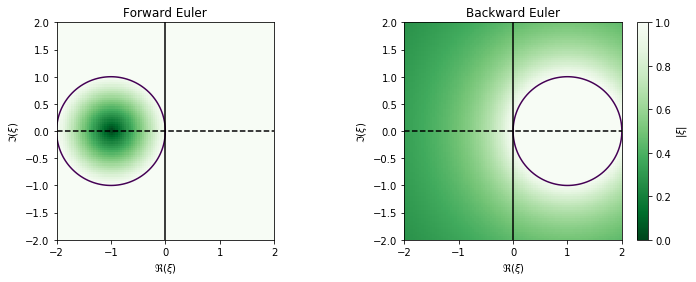

In [23]:
x = numpy.linspace(-2, 2, 100)
y = numpy.linspace(-2, 2, 100)
X, Y = numpy.meshgrid(x, y)
Z = X + 1j * Y

fig, axes = plt.subplots(1, 2)
fig.set_figwidth(fig.get_figwidth() * 2)
pcolor_plot = axes[0].pcolor(X, Y, numpy.abs(1 + Z), vmin=0.0, vmax=1.0, cmap=plt.get_cmap('Greens_r'))
axes[0].contour(X, Y, numpy.abs(1 + Z), levels=[1.0])
axes[0].plot(x, numpy.zeros(x.shape),'k--')
axes[0].plot(numpy.zeros(y.shape), y,'k')
axes[0].set_aspect('equal')
axes[0].set_title("Forward Euler")
axes[0].set_xlabel(r"$\Re(\xi)$")
axes[0].set_ylabel(r"$\Im(\xi)$")

pcolor_plot = axes[1].pcolor(X, Y, numpy.abs(1.0 / (1.0 - Z)), vmin=0.0, vmax=1.0, cmap=plt.get_cmap('Greens_r'))
axes[1].contour(X, Y, numpy.abs(1.0 / (1.0 - Z)), levels=[1.0])
axes[1].plot(x, numpy.zeros(x.shape),'k--')
axes[1].plot(numpy.zeros(y.shape), y,'k')
axes[1].set_aspect('equal')
axes[1].set_title("Backward Euler")
axes[1].set_xlabel(r"$\Re(\xi)$")
axes[1].set_ylabel(r"$\Im(\xi)$")

cbar = fig.colorbar(pcolor_plot)
cbar.set_label(r"$|\xi|$")
plt.show()

### Plotting the contours

If we think of the roots of the stability polynomial $\xi_j$ as complex numbers and write them in exponential form 

$$\xi_j = |\xi_j| e^{i \theta}.$$ 

Here $|\xi_j|$ is the modulus (or magnitude) or the complex number and is defined as $|\xi_j| = x^2 + y^2$ where $\xi_j = x + i j$.  If the $\xi_j$s are on the boundary of the absolute stability region then we know that $|\xi_j| = 1$.  Using this in conjunction with the stability polynomial then leads to 

$$\rho(e^{i\theta}) - z \sigma(e^{i\theta}) = 0$$

which solving for $z$ leads to

$$z(\theta) = \frac{\rho(e^{i\theta})}{\sigma(e^{i\theta})}.$$

As an example consider the Adams-Bashforth 2-stage method.  The stability polynomial can be found as
$$\begin{aligned}
    U_{n+2} &= U_{n+1} + \frac{\Delta t}{2} (-f(U_n) + 3 f(U_{n+1})) \\
    \pi(\xi, z) &= U_{n+2} - U_{n+1} - \frac{\Delta t}{2} (-f(U_n) + 3 f(U_{n+1})) = 0 \\
    &= U_{n+2} - U_{n+1} - \frac{1}{2} (\Delta t \lambda U_n - 3 \Delta t \lambda U_{n+1}) \\
    &= 2 \xi^2 - 2 \xi + 3 z\xi - z \\
    &= \rho(\xi, z) + z \sigma(\xi, z)
\end{aligned}$$
where
$$
    \rho(\xi, z) = 2 ( \xi - 1) \xi ~~~ \text{and} ~~~ \sigma(\xi, z) = 3 \xi - 1
$$
so that
$$
    z(\theta) = \frac{2 (\xi - 1) \xi}{3 \xi - 1}.
$$

This does not necessarily ensure that given a $\theta$ that $z(\theta)$ will lie on the absolute stability region's boundary.  This can occur when $\xi_j = 1$ but to the left and right of the curve $\xi_j > 1$ and so therefore does not mark the boundary of the region.  To determine whether a particular region outlined by this curve is inside or outside of the stability region we can evaluate all the roots of $\pi(\xi, z)$ at some $z$ inside of the region in question and see if then $\forall j, \xi_j < 1$.

For one-step methods this becomes easier, if we look at the ratio $R(z)$ we defined earlier as
$$
    U_{n+1} = R(z) U_n
$$
in the case of the pth order Taylor series method applied to $u'(t) = \lambda u$ we get

$$\begin{aligned}
    U_{n+1} &= U_n + \Delta t \lambda U_n + \frac{1}{2}\Delta t^2 \lambda^2 U_n + \cdots + \frac{1}{p!}\Delta t^p \lambda^p U_n \\
    &=\left(1 + z + \frac{1}{2} z^2 + \frac{1}{6} z^3 + \cdots +\frac{1}{p!}z^p\right) U_n \Rightarrow \\
    R(z) &= 1 + z + \frac{1}{2} z^2 + \frac{1}{6} z^3 + \cdots +\frac{1}{p!}z^p.
\end{aligned}$$

Setting $R(z) = e^{i\theta}$ could lead to a way for solving for the boundary but (where $|R(z)| = 1$) but this is very difficult to do in general.  Instead if we plot the contours of $R(z)$ in the complex plane we can pick out the $R(z)=1$ contour and plot that.

Forward Euler's method - Stability region tests
  Inside of circle:  0.0
  Outside of circle:  2.0
Backward Euler's method - Stability region tests
  Inside of circle:  1.0
  Outside of circle:  0.447213595499958
Taylor series method of order 4 - Stability region tests
  Inside of strange region:  0.37500000000000006
  Outside of strange region:  5.0


(-2, 2)

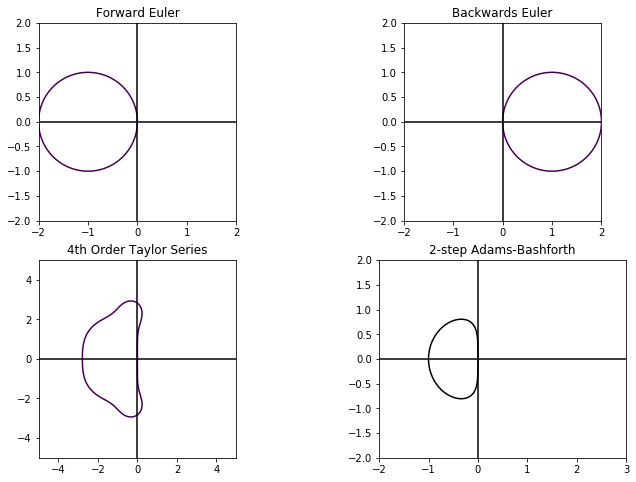

In [24]:
theta = numpy.linspace(0.0, 2.0 * numpy.pi, 100)

# ==================================
#  Forward euler
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)
axes = fig.add_subplot(2, 2, 1)
x = numpy.linspace(-2, 2, 100)
y = numpy.linspace(-2, 2, 100)
X, Y = numpy.meshgrid(x, y)
Z = X + 1j * Y

# Evaluate which regions are actually in stability region
print("Forward Euler's method - Stability region tests")
z = -1 + 1j * 0
print("  Inside of circle: ", numpy.abs(1.0 + z))
z = -3 + 1j * 0
print("  Outside of circle: ", numpy.abs(1.0 + z))

axes.contour(X, Y, numpy.abs(1.0 + Z), levels=[1.0])
axes.plot(x, numpy.zeros(x.shape),'k')
axes.plot(numpy.zeros(y.shape), y,'k')
axes.set_aspect('equal')
axes.set_title("Forward Euler")

# ==================================
#  Backwards Euler
axes = fig.add_subplot(2, 2, 2)
x = numpy.linspace(-2, 2, 100)
y = numpy.linspace(-2, 2, 100)
X, Y = numpy.meshgrid(x, y)
Z = X + 1j * Y

# Evaluate which regions are actually in stability region
print("Backward Euler's method - Stability region tests")
z = 1 + 1j
print("  Inside of circle: ", numpy.abs(1.0 / (1.0 - z)))
z = -1 + 1j
print("  Outside of circle: ", numpy.abs(1.0 / (1.0 - z)))

axes.contour(X, Y, numpy.abs(1.0 / (1.0 - Z)), levels=[1.0])
axes.plot(x, numpy.zeros(x.shape),'k')
axes.plot(numpy.zeros(y.shape), y,'k')
axes.set_aspect('equal')
axes.set_title("Backwards Euler")

# ==================================
#  Taylor series method of order 4
axes = fig.add_subplot(2, 2, 3)
x = numpy.linspace(-5, 5, 100)
y = numpy.linspace(-5, 5, 100)
X, Y = numpy.meshgrid(x, y)
Z = X + 1j * Y

# Evaluate which regions are actually in stability region
print("Taylor series method of order 4 - Stability region tests")
z = -1 + 1j * 0
print("  Inside of strange region: ", numpy.abs(1 + z + 0.5 * z**2 + 1.0/6.0 * z**3 + 1.0 / 24.0 * z**4))
z = -4 + 1j * 0
print("  Outside of strange region: ", numpy.abs(1 + z + 0.5 * z**2 + 1.0/6.0 * z**3 + 1.0 / 24.0 * z**4))

axes.contour(X, Y, numpy.abs(1 + Z + 0.5 * Z**2 + 1.0/6.0 * Z**3 + 1.0 / 24.0 * Z**4), levels=[1.0])
axes.plot(x, numpy.zeros(x.shape),'k')
axes.plot(numpy.zeros(y.shape), y,'k')
axes.set_aspect('equal')
axes.set_title("4th Order Taylor Series")

# ==================================
# 2-step Adams-Bashforth
theta = numpy.linspace(0.0, 2.0 * numpy.pi, 1000)
xi = numpy.exp(1j * theta)

rho_2AB = lambda xi: 2.0 * (xi - 1.0) * xi
sigma_2AB = lambda xi: 3.0 * xi - 1.0
z_2AB = rho_2AB(xi) / sigma_2AB(xi)
z = rho_2AB(xi) / sigma_2AB(xi)

axes = fig.add_subplot(2, 2, 4)
axes.plot(z_2AB.real, z_2AB.imag, 'k')
axes.plot(x, numpy.zeros(x.shape),'k')
axes.plot(numpy.zeros(y.shape), y,'k')
axes.set_title("2-step Adams-Bashforth")
axes.set_aspect('equal')
axes.set_xlim([-2, 3])
axes.set_ylim([-2, 2])

